In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     cross_val_score, 
                                     GridSearchCV)
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [47]:
import xgboost
import catboost
import lightgbm

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

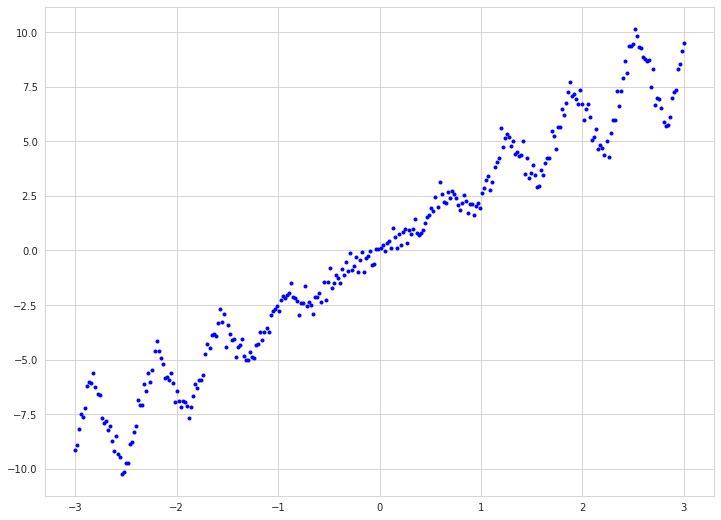

In [4]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [5]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

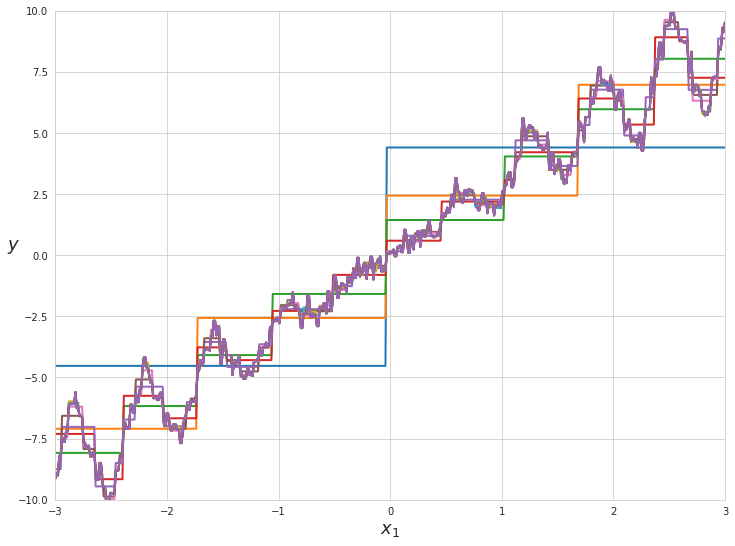

In [6]:
for el in range(1,16):
    tree_reg = DecisionTreeRegressor(max_depth=el)
    tree_reg.fit(X,y)
    plot_regression_predictions(tree_reg, X, y)

<span style="color:green">Для дерева решений показано, что с увеличением грубины предсказания дерева всё ближе приближаются к истинным значениям</span>

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [10]:
def majority_vote_p(n_classif):
    if n_classif % 2 == 0:
        i = int(n_classif / 2)
    else:
        i = int((n_classif + 1) / 2)
    a = []
    for k in range(0, 101):
        sum = 0
        for m in range(i, n_classif + 1):
            sum += math.factorial(n_classif) / math.factorial(n_classif - m) / math.factorial(m) * ((0.01 * k)**m) * ((1 - 0.01 * k)**(n_classif - m))
        a.append(sum)
    return a

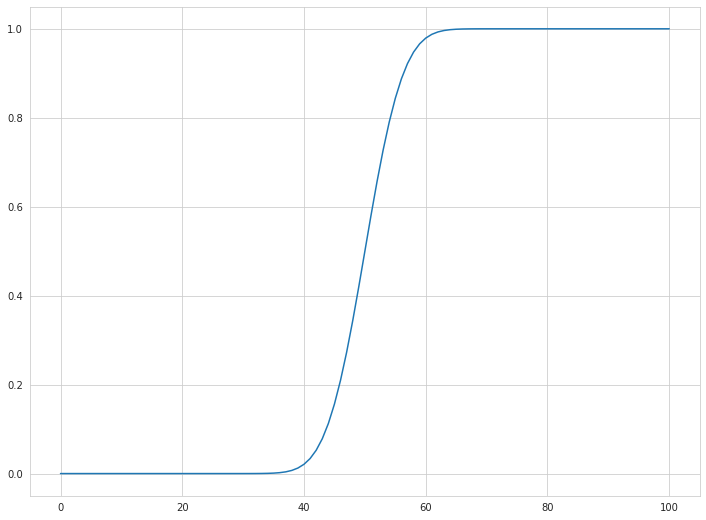

In [11]:
res = majority_vote_p(101)
plt.plot(res)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [12]:
def majority_vote_n(n_classif, p):
    a = []
    for k in range(1, n_classif + 1):
        sum = 0
        if k % 2 == 0:
            i = int(n_classif / 2)
        else:
            i = int((n_classif + 1) / 2)
        for m in range(i, k + 1):
            sum += math.factorial(k) / math.factorial(k - m) / math.factorial(m) * (p**m) * ((1 - p)**(k - m))
        a.append(sum)
    return a

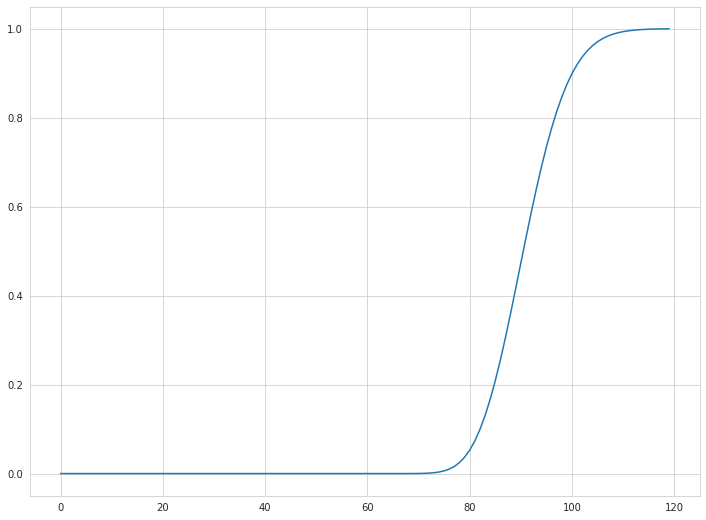

In [14]:
res = majority_vote_n(120, 0.65)
plt.plot(res)
plt.show()

Опишите ваши наблюдения:

* <span style="color:green">При увеличении вероятности p правильно предсказать класс объекта каждым классификатором, общая вероятность возрастает. </span>
* <span style="color:green">При увеличении числа классификаторов общая вероятность правильно классифицировать объект возрастает. </span>

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [15]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for i in range(self.n_estimators - 1):
            self.max_features = int(math.sqrt(X.shape[1]))
            w = np.random.choice(X.shape[1], size = self.max_features, replace=False)
            self.feat_ids_by_tree.append(w)
            X_some_cols = X[:, w]
            p = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            X_boot = X_some_cols[p]
            y_boot = y[p]
            dt = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, 
                                        random_state=self.random_state + i)
            dt.fit(X_boot, y_boot)
            self.trees.append(dt)
        return self

    def predict_proba(self, X):
        pred_prob = []
        for el in range(len(self.trees)):
            a = self.trees[el].predict_proba(X[:, self.feat_ids_by_tree[el]])
            a_np = np.argmax(a, axis=1)
            pred_prob.append(a_np)
        pred_prob = np.array(pred_prob)
        return pred_prob
    
    def predict(self, X):
        probas = self.predict_proba(X)
        a = np.average(probas, axis = 0)
        predictions = []
        for el in a:
            if el > 0.5:
                predictions.append(1)
            if el < 0.5:
                predictions.append(0)
            if el == 0.5:
                predictions.append(random.choice([0, 1]))
        return np.array(predictions)

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [16]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

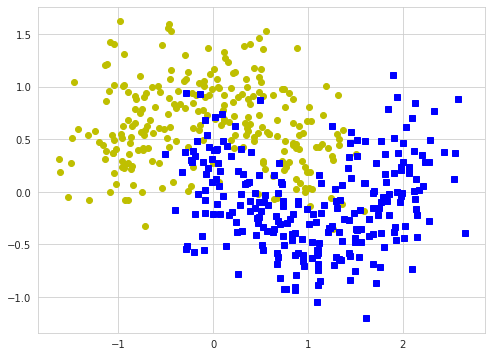

In [17]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

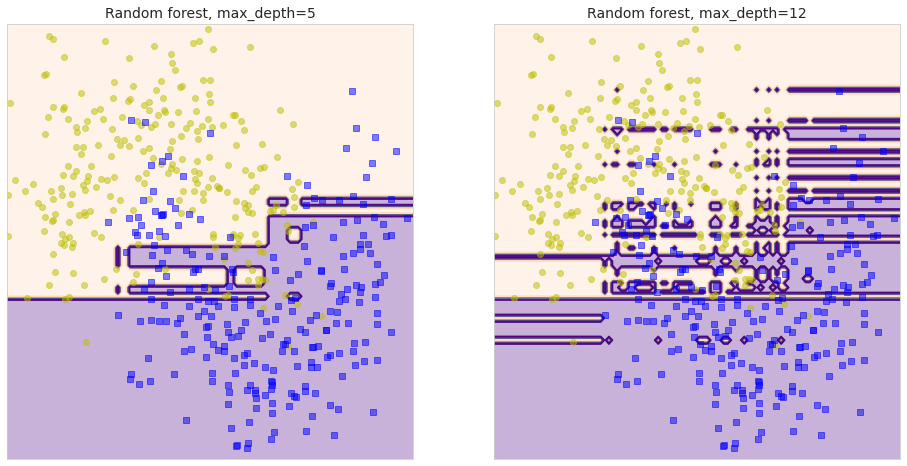

In [28]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
rf5 = RandomForestClassifierCustom(n_estimators = 10, max_depth=3) 
rf5.fit(X_train, y_train)
plot_decision_boundary(rf5, X, y)
plt.title("Random forest, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(122)
rf12 = RandomForestClassifierCustom(n_estimators = 200, max_depth=12) 
rf12.fit(X_train, y_train)
plot_decision_boundary(rf12, X, y)
plt.title("Random forest, max_depth=12", fontsize=14)
plt.subplots_adjust()
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], []);

<span style="color:green">Мой лес сильно переобучается, вероятно, где-то ошибка. В лекции random forest вел себя хорошо, а мой ведет себя плохо: разделяющая граница слишком ломаная</span>

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [29]:
rf = RandomForestClassifierCustom()
param = {"n_estimators" : [10, 20, 30, 50, 100], "max_depth" : [2, 3, 4, 5, 7, 10, 15, 20]}
grid_search = GridSearchCV(rf, param, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifierCustom(),
             param_grid={'max_depth': [2, 3, 4, 5, 7, 10, 15, 20],
                         'n_estimators': [10, 20, 30, 50, 100]},
             scoring='f1')

In [30]:
grid_search.best_params_

{'max_depth': 3, 'n_estimators': 100}

In [31]:
best_rf = grid_search.best_estimator_

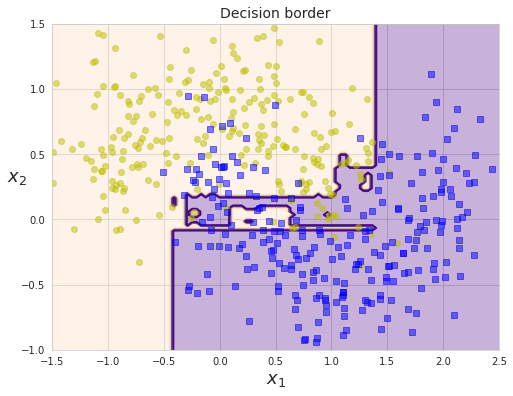

In [32]:
plt.figure(figsize=(8, 6))
best_rf.fit(X_train, y_train)
plot_decision_boundary(best_rf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

<img src ="https://pbs.twimg.com/profile_images/378800000732180947/c3f15b014477cb4c2d0b057d0810f21f_400x400.jpeg" width="300" length="300">

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [35]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [36]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [37]:
corr = []
for i in range(1, X.shape[1] + 1):
    clf = RandomForestClassifier(max_features = i)
    clf.fit(X_train, y_train)
    corr.append(base_model_pair_correlation(clf, X_test))

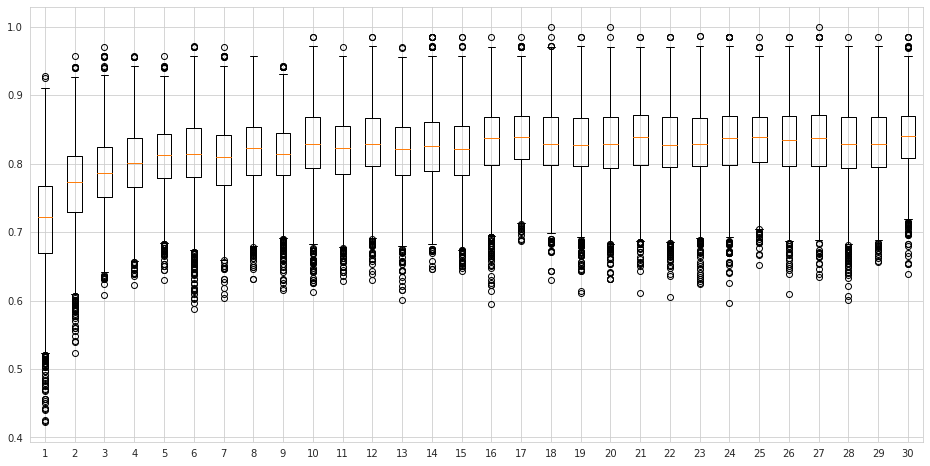

In [39]:
fig = plt.figure(1, figsize=(16, 8))
plt.boxplot(corr);

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [40]:
corr_depths = []
for i in range(1, 51):
    clf = RandomForestClassifier(max_depth = i)
    clf.fit(X_train, y_train)
    corr_depths.append(base_model_pair_correlation(clf, X_test))

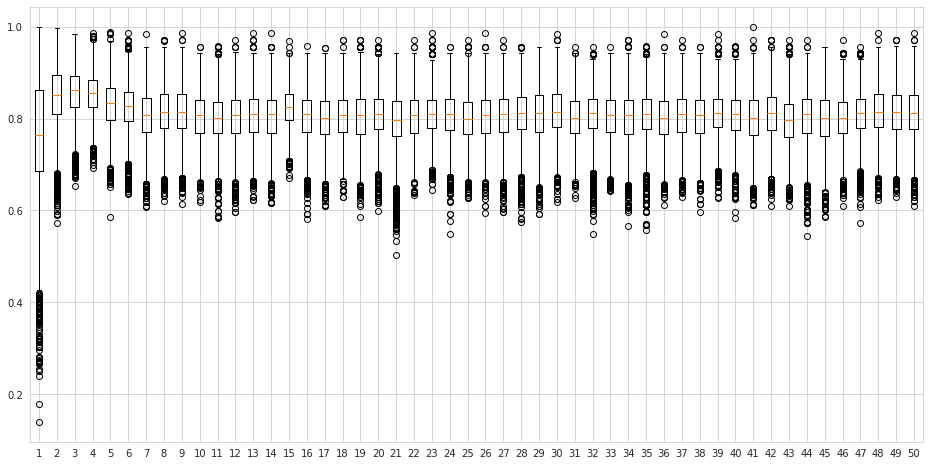

In [41]:
fig = plt.figure(1, figsize=(16, 8))
bp = plt.boxplot(corr_depths)

Опишите ваши наблюдения:

<span style="color:green">Вот такие результаты. И мне кажется, что графики не должны так выглядеть. С увеличением числа фичей, которые мы выбираем при генерации леса, мне кажется, корреляция должна возрастать. А при увеличении грубины деревьев, наверно, наоборот будет убывать (мне так кажется). Но по этим графикам сложно судить, потому что они практически не меняются.</span>

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за эксперименты и максимально высокий скор**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).

In [42]:
!gdown 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [43]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


In [44]:
X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [48]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB_RF", xgb_rf),
               ("XGB", xgb), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [49]:
for el in base_models:
    el[1].fit(X_train, y_train)

voting_hard = VotingClassifier(estimators=base_models)
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, lgbm, lgbm_rf, xgb_rf, xgb, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

[22:46:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:46:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:46:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:46:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [50]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [62]:
corr_base_models = []
for el in [voting_hard, voting_soft]:
    el.fit(X_train, y_train)
    corr_base_models.append(base_model_pair_correlation_for_voting_clf(el, X_test))

[23:05:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [66]:
corr_base_models

[[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
   RandomForestClassifier(n_estimators=50, random_state=111),
   0.8134894007824363),
  (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
   ExtraTreesClassifier(random_state=111),
   0.7749544834941166),
  (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
   KNeighborsClassifier(weights='distance'),
   0.31332949662835446),
  (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
   SVC(kernel='linear', probability=True, random_state=111),
   0.715376472596946),
  (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
   SVC(probability=True, random_state=111),
   0.28201353566953774),
  (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
   0.7875690140798682),
  (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
   LGBMClassifier(random_state=111),
   

<span style="color:green">В общем, я опять недовольна тем, что у меня получается )) Я немного запуталась: возможно, я неправильно понимаю, к чему эту функцию я должна применить, а я думала, что к base_models или к [voting_hard, voting_soft]. Это достаточно странный формат получаемых результатов, поиому что полагала, что он должен быть похожим на результат функции base_model_pair_correlation. Можно выбрать наиболее скоррелированные модели</span>\
<span style="color:green">Много моделей убрала, но качество чуть улучшилось </span>

In [109]:
base_models = [("DT", dt), ("SVC_LIN", svc_lin), ("LGBM", lgbm), ("XGB", xgb), ("LR", lr)]

voting_hard = VotingClassifier(estimators=base_models)
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

for model in [voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

[23:41:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:41:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:41:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:41:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

<span style="color:green">Следующее задание не успела выполнить</span>

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [130]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

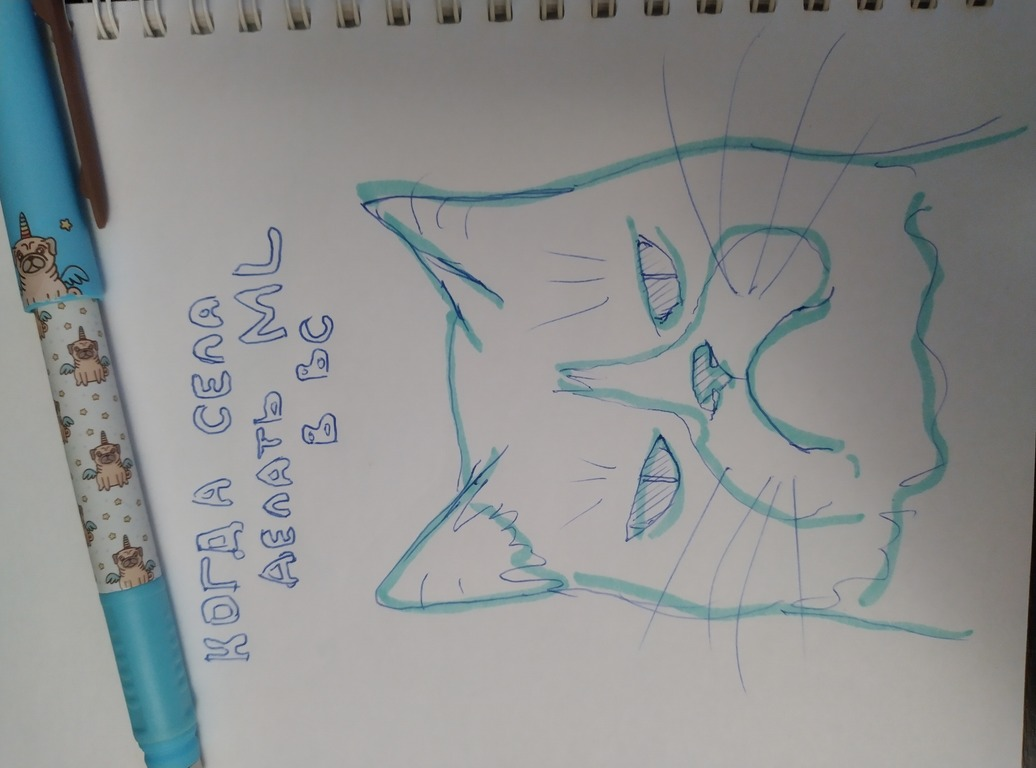

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

<span style="color:green">Никого, кроме себя, не обвиняю в своем неуспевании, слишком загруженная была неделя. Жаль, что не всё успела, а в том, что успела, вообще не уверенна :) Ну хорошо хоть у меня всегда остается работа над ошибками.</span>